In [1]:
!tar xf drive/MyDrive/resized.tar.gz

In [2]:
import json
import torch

class GoodNews(torch.utils.data.Dataset):

    def __init__(self, split='train', transform=None):
        self.transform = transform
        f = open(f"./{split}_set.json")
        data = json.load(f)
        self.img_headline_pair = [(f'./resized/{k}', data[k]['headline'], data[k]['caption']) for k in data.keys()]
        self.img_headline_pair = sorted(self.img_headline_pair, key=lambda x: x[0])

        f.close()

    def __getitem__(self, index):
        image = Image.open(self.img_headline_pair[index][0]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.img_headline_pair[index][1], self.img_headline_pair[index][2]

    # Return the total number of samples.
    def __len__(self):
        return len(self.img_headline_pair)

In [4]:
! pip install git+https://github.com/openai/CLIP.git --quiet

     |████████████████████████████████| 53 kB 2.1 MB/s 


In [36]:
a = [1,2,3,4,5,6]
print(a[:6])

[1, 2, 3, 4, 5, 6]


In [37]:
import clip
from PIL import Image
import numpy as np
from tqdm import tqdm
import pickle

with open('test_set_image_features.pickle', 'rb') as handle:
    batchwise_image_features = pickle.load(handle)

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

testset = GoodNews(split = 'test', transform=preprocess)
top10_accuracy = 0
top5_accuracy = 0
top1_accuracy = 0
res_top1 = []
res_top5 = []
res_top10 = []

progression_bar = tqdm(range(len(testset)))

for i in (progression_bar):
    progression_bar.set_description(f'T10: {round(top10_accuracy/(i+1), 3)}, T5: {round(top5_accuracy/(i+1), 3)}, T1: {round(top1_accuracy/(i+1), 3)}')

    _, headline, caption = testset[i]
    caption = caption[:77]
    text = clip.tokenize([caption]).to(device) #Change between headline and caption here
    text_features = model.encode_text(text)

    text_features /= text_features.norm(dim=-1, keepdim=True).detach()

    similarities = []
    for image_features_batch in batchwise_image_features:

        image_features_batch = image_features_batch.to(device)
        image_features_batch /= image_features_batch.norm(dim=-1, keepdim=True)

        similarity = (100.0 * image_features_batch @ text_features.T)
        similarity = similarity.cpu()

        for x in similarity:
            similarities.append(x[0].item())

    similarities = np.array(similarities)
    sorted_indexes = np.argsort(similarities)
    similarities = np.sort(similarities)
    if sorted_indexes[-1] == i:
        top1_accuracy += 1
        res_top1.append((i, sorted_indexes[-10:], similarities[-10:]))
    if i in sorted_indexes[-5:]:
        top5_accuracy += 1
        if len(res_top5) <= 1000:
          res_top5.append((i, sorted_indexes[-10:], similarities[-10:]))
    if i in sorted_indexes[-10:]:
        top10_accuracy += 1
        if len(res_top10) <= 1000:
          res_top10.append((i, sorted_indexes[-10:], similarities[-10:]))


print(top10_accuracy)
print(top5_accuracy)
print(top1_accuracy)

print(top10_accuracy/len(testset))
print(top5_accuracy/len(testset))
print(top1_accuracy/len(testset))


T10: 0.657, T5: 0.602, T1: 0.406: 100%|██████████| 5000/5000 [05:26<00:00, 15.31it/s]

3283
3012
2031
0.6566
0.6024
0.4062


In [48]:
t5_indices = {}
t5_similarities = {}
t10_indices = {}
t10_similarities = {}

for i, top10_indices, top10_similarities in res_top5:
  t5_indices[i] = top10_indices
  t5_similarities[i] = top10_similarities

for i, top10_indices, top10_similarities in res_top10:
  t10_indices[i] = top10_indices
  t10_similarities[i] = top10_similarities

for i in t10_indices:
  if i not in t5_indices:
    print(i)
    break


8


8
Touchdown, in Style: Giants Leave the Injured Back at Home, for Now

A member of the flight crew displayed her loyalty as the Giants disembarked on Monday in Indianapolis in preparation for Super Bowl XLVI on Sunday.


./resized/4fd2a4268eb7c8105d88a657_0.jpg


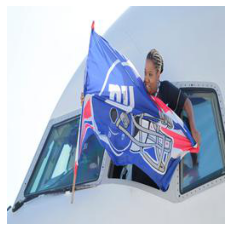

In [49]:
import matplotlib.pyplot as plt

# result_list = res_top1
# result_list = res_top5
result_list = res_top10
test_index = 2
test_set = GoodNews(split = 'test')
# index = result_list[test_index][0]
# top10_indices = result_list[test_index][1]
# top10_similarities = result_list[test_index][2]
index = 8
top10_indices = t10_indices[index]
top10_similarities = t10_similarities[index]
img, headline, caption = test_set[index]
img_name = test_set.img_headline_pair[index][0]

print(index)
print(headline)
print(caption)
print(img_name)
plt.figure();plt.imshow(img);
plt.grid(False); plt.axis('off'); plt.show()

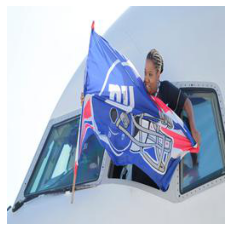

In [50]:
image = Image.open(img_name).convert('RGB')
plt.figure();plt.imshow(image);
plt.grid(False); plt.axis('off'); plt.show()

./resized/540f93de38f0d87641c67ed0_0.jpg
./resized/57954c2338f0d838f06b9b5f_0.jpg
./resized/4fd2a4268eb7c8105d88a657_0.jpg
./resized/57ebe90a95d0e021d7988de6_0.jpg
./resized/56732d2c38f0d85bed90f3d5_0.jpg
./resized/57c3732a95d0e021d7983157_0.jpg
./resized/51c378c07e0d9c0839d2a81d_0.jpg
./resized/58ffb1e795d0e024b586d44c_0.jpg
./resized/55c4c2b738f0d83840aed69e_0.jpg
./resized/50b5078d00315214fbb7c038_0.jpg


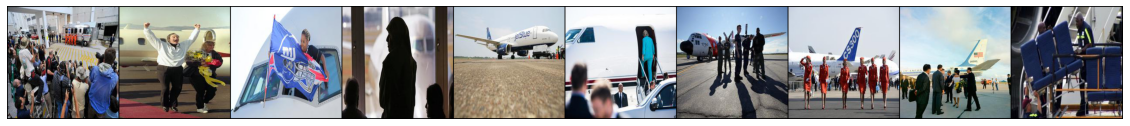

In [51]:
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as transforms

def plot_imgs(imgs):
    grid = torchvision.utils.make_grid(imgs, nrow = 10)
    plt.figure(figsize=(20,10)); plt.axis(False)
    plt.imshow(F.to_pil_image(grid));

t = transforms.ToTensor()
imgs = []
for i in top10_indices:
  img, headline, caption = test_set[i]
  img = t(img)
  imgs.append(img)
  img_name = test_set.img_headline_pair[i][0]
  print(img_name)

plot_imgs(imgs)

In [52]:
print(top10_similarities)

[27.734375 27.78125  27.9375   28.140625 28.609375 29.09375  29.125
 29.28125  29.59375  30.453125]
